# Binary classification for toxic comment prediction

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
#To mute cuda errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

model_folder = "models"

base_folder = os.getcwd()
print(base_folder)

model_path = os.path.join(base_folder, model_folder)

if not os.path.exists(model_path):
    os.makedirs(model_path)
    
BOW_VECT_PICKLE = "bow_vect.pkl"
BOW_NORM_PICKLE = "bow_norm.pkl"

TfIDf_VECT_PICKLE = "tfidf_vect.pkl"
TfIDf_NORM_PICKLE = "tfidf_norm.pkl"



D:\z_ML\ML_project\NLP


In [2]:
def write_pickle(obj, fileName):
    pickle_file_path = os.path.join(model_path, fileName)
    pickle.dump(obj, open(pickle_file_path, "wb"))

def read_pickle(fileName):
    pickle_file_path = os.path.join(model_path, fileName)
    return pickle.load(open(pickle_file_path, "rb"))

In [3]:
import pandas as pd

df = pd.read_csv('data/train.csv')
print(df.shape)
df.columns

(159571, 8)


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [4]:
df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [5]:
df.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [6]:
toxic = df[df['toxic'] == 1].head(1000)
clean = df[df['toxic'] == 0].head(1000)
frames = [toxic, clean]
df = pd.concat(frames)

In [7]:
df = df.sample(frac=1)
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
676,01d4b7933d888580,"""\n— Preceding unsigned comment added by (tal...",0,0,0,0,0,0
3919,0a751ed4b4da7890,YOU ARE A MINDLESS FAGGOT PIG PLEASE GOD BURN ...,1,1,1,0,1,0
25,000eefc67a2c930f,Radial symmetry \n\nSeveral now extinct lineag...,0,0,0,0,0,0
2176,05e65404071455d5,What the fuck gose here,1,0,1,0,0,0
8421,1664c3486a906a38,"""\n""""To denude it of its context is obscene?""""...",1,0,0,0,0,0


### We only need comment and toxic label for our model

In [8]:
df = df[['comment_text', 'toxic']]

In [9]:
unseen_data_to_check = df.iloc[0:30]
df = df.iloc[30:2000]
print(df.shape)

(1970, 2)


In [10]:
frames1 = [unseen_data_to_check, df]
df_used = pd.concat(frames1)

##For future ref we save the data used
df_used.to_csv("toxic_data_2000.csv")

In [11]:
df.toxic.value_counts()

1    986
0    984
Name: toxic, dtype: int64

## EDA before Datacleaning

In [20]:
#https://thecleverprogrammer.com/2022/06/22/count-number-of-words-in-a-column-using-python/
df["No_of_Words"] = df["comment_text"].apply(lambda n: len(n.split()))
print(df.head())

                                           comment_text  toxic  No_of_Words
4492  you are sick bastard, and hope get your lesson...      1           10
803   I have seen your post now but I replaced the p...      0           23
8260  Why did you remove musical artist discography,...      1           43
8355  I hope to God your kids are trapped inside bur...      1           11
5546  hey shithead \n\nquit fucking with all the ufc...      1           21


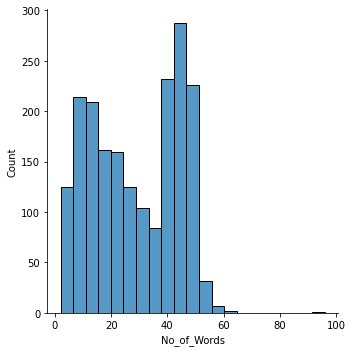

In [21]:
import seaborn as sns
sns.displot(data=df, x=df.No_of_Words)

In [22]:
df['comment_text'] = df['comment_text'].str[:255]

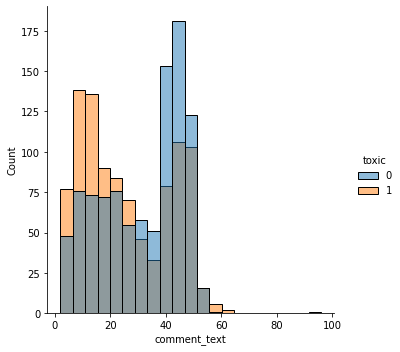

In [23]:
sns.displot(data=df, x=df.comment_text.str.split().str.len(), hue="toxic")

In [24]:
print(df['comment_text'][0:15].values)

['you are sick bastard, and hope get your lesson soon'
 'I have seen your post now but I replaced the pop punk reference which was there again with rock a few days before.'
 "Why did you remove musical artist discography, not images?\n\nThough most of musical artists CD, DVD images are permitted, why are B'z, Jun Shibata album covers removed? X Japan (see X Japan discography), Glay (see Glay discography) and Dir en grey (see Dir"
 'I hope to God your kids are trapped inside burning cars.'
 'hey shithead \n\nquit fucking with all the ufc pages and go get a fucking life you god damn mother fucking loser.'
 'do not delete my comment you zionist\n\nyou are not allowed to delete my comment, so please do not do that! once it is up it is up! i have been warned, so there is no need for deleting it. if you are, then get rid of the warning! i have read the rules. also'
 "Scope\nPlease see the link above, as I'm sure you are a fucking spastic"
 'No silly it isnt ITS UR MOMS and might I say quite 

## Data cleaning

In [25]:
# Removing spl characters/punctuations
import re

text = "This is \nti\nme This is http://www.google.com a at this @day  423% why it's happening ??"

text = re.sub('http://\S+|https://\S+', '', text)
print("HTML removed :: ",text)

text = re.sub("\n|\r|'", "", text) #Remove spl characters \n \r and replace with ""
print("\n removed ::",text)

text = re.sub('[^A-Za-z]+', ' ', text) #keep only characters, remove numbers and spl characters and replace with ' '
print(text)

my_string = "my phone number is 12 345 6789"
my_string = re.sub(r'(\d)\s+(\d)', r'\1\2', my_string) # Remove extra space between numbers
print(my_string)

HTML removed ::  This is 
ti
me This is  a at this @day  423% why it's happening ??

 removed :: This is time This is  a at this @day  423% why its happening ??
This is time This is a at this day why its happening 
my phone number is 123456789


In [26]:
# Removing spl characters/punctuations
seperator = 'http'
sample_text = "This is a http r 343034"
stripped = sample_text.split(seperator, 1)[0]
stripped

'This is a '

In [27]:
#https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words

# Spliting words meaningfully
import wordninja
words = wordninja.split('this is given lotharderthanitlooks ')
#words = ' '.join(words)
words

['this', 'is', 'given', 'lot', 'harder', 'than', 'it', 'looks']

In [28]:
#https://towardsdatascience.com/build-a-spelling-corrector-program-in-python-46bc427cf57f
#!pip install textblob

#Spelling check
from textblob import TextBlob

sentence = TextBlob('A sentencee to checkk!')
sentence.correct()

TextBlob("A sentence to check!")

In [29]:
txt = "rt I like bananas"

txt = txt.replace("rt", "apples")

print(txt)

apples I like bananas


In [30]:
def clean_data(sentence):
    
    #Remove @ sign and the characters followed by @sign
    sentence = re.sub('http://\S+|https://\S+', '', sentence)
    
    sentence = re.sub("\n|\r|'","",sentence)
    
    #Keep only numbers, text and %
    sentence  = re.sub('[^A-Za-z]+', ' ', sentence)  
    
    #Remove exta space between words
    sentence = re.sub(' +', ' ', sentence)
    
    #fix wrong spellings and return
    #sentence = TextBlob(sentence).correct() 
    
    sentence = sentence.strip()
    return str(sentence).lower()


df['comment_text_cleaned'] = df['comment_text'].apply(clean_data)
print(df['comment_text'][0:15].values)
df['comment_text_cleaned'][0:15].values

['you are sick bastard, and hope get your lesson soon'
 'I have seen your post now but I replaced the pop punk reference which was there again with rock a few days before.'
 "Why did you remove musical artist discography, not images?\n\nThough most of musical artists CD, DVD images are permitted, why are B'z, Jun Shibata album covers removed? X Japan (see X Japan discography), Glay (see Glay discography) and Dir en grey (see Dir"
 'I hope to God your kids are trapped inside burning cars.'
 'hey shithead \n\nquit fucking with all the ufc pages and go get a fucking life you god damn mother fucking loser.'
 'do not delete my comment you zionist\n\nyou are not allowed to delete my comment, so please do not do that! once it is up it is up! i have been warned, so there is no need for deleting it. if you are, then get rid of the warning! i have read the rules. also'
 "Scope\nPlease see the link above, as I'm sure you are a fucking spastic"
 'No silly it isnt ITS UR MOMS and might I say quite 

array(['you are sick bastard and hope get your lesson soon',
       'i have seen your post now but i replaced the pop punk reference which was there again with rock a few days before',
       'why did you remove musical artist discography not images though most of musical artists cd dvd images are permitted why are bz jun shibata album covers removed x japan see x japan discography glay see glay discography and dir en grey see dir',
       'i hope to god your kids are trapped inside burning cars',
       'hey shithead quit fucking with all the ufc pages and go get a fucking life you god damn mother fucking loser',
       'do not delete my comment you zionistyou are not allowed to delete my comment so please do not do that once it is up it is up i have been warned so there is no need for deleting it if you are then get rid of the warning i have read the rules also',
       'scopeplease see the link above as im sure you are a fucking spastic',
       'no silly it isnt its ur moms and mig

## part 1:: Feature-engineering :: Encode the raw text with Sentence Transformer

In [31]:
#https://www.sbert.net/docs/pretrained_models.html
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

sent_transformer_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = sent_transformer_model.encode(sentences)
print(embeddings)

[[ 0.0225026  -0.07829177 -0.02303074 ... -0.00827928  0.02652693
  -0.00201897]
 [ 0.04170236  0.0010974  -0.01553419 ... -0.02181627 -0.06359356
  -0.00875284]]


In [32]:
df['comment_sent_encoder_embeddings'] = df['comment_text_cleaned'].apply(sent_transformer_model.encode)
df['comment_sent_encoder_embeddings'].head(2)

4492    [0.018885124, 0.05722584, 0.013438828, -0.0060...
803     [0.018473262, -0.01152733, -0.022863047, 0.013...
Name: comment_sent_encoder_embeddings, dtype: object

## part2:: Feature-engineering :: To pass text to other vectorizer like BOW, TfIdf

In [33]:
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
import spacy
import string

spacy_model = spacy.load("en_core_web_sm")
stop_words = spacy_model.Defaults.stop_words

In [34]:
# Creating spacy tokenizer function
def create_spacy_tokens(sentence):
    
    # Creating token object for all sentence
    document = spacy_model(sentence)
    print(document)

    # Lemmatizing every token
    tokens = [ word.lemma_.strip() for word in document ]
    
    # Removing stopwords
    sentence = " ".join([ word for word in tokens if word not in stop_words ])
    
    print("cleaned ::",sentence)
    return sentence

## sample text
create_spacy_tokens('I am drawing')

I am drawing
cleaned :: I draw


'I draw'

In [35]:
df['comment_tokens'] = df['comment_text_cleaned'].apply(create_spacy_tokens)

you are sick bastard and hope get your lesson soon
cleaned :: sick bastard hope lesson soon
i have seen your post now but i replaced the pop punk reference which was there again with rock a few days before
cleaned :: I post I replace pop punk reference rock day
why did you remove musical artist discography not images though most of musical artists cd dvd images are permitted why are bz jun shibata album covers removed x japan see x japan discography glay see glay discography and dir en grey see dir
cleaned :: remove musical artist discography image musical artist cd dvd image permit bz jun shibata album cover remove x japan x japan discography glay glay discography dir en grey dir
i hope to god your kids are trapped inside burning cars
cleaned :: I hope god kid trap inside burn car
hey shithead quit fucking with all the ufc pages and go get a fucking life you god damn mother fucking loser
cleaned :: hey shithead quit fucking ufc page fucking life god damn mother fucking loser
do not de

check the diff swedefag
cleaned :: check diff swedefag
review request hi id like to request klm for a ga class review can anyone do that it seems to have many similar stuff to other gas such as kenya airways and ethiopian airlines cheers breaksfixes
cleaned :: review request hi d like request klm ga class review similar stuff gas kenya airways ethiopian airline cheer breaksfixe
re aip go fuck yourself thefortyfive
cleaned :: aip fuck thefortyfive
vandalism spreeyour vandalism spree is pitiful all this after i supported your motions thanks a lot
cleaned :: vandalism spreeyour vandalism spree pitiful I support motion thank lot
in the anus with a nigger dick in it
cleaned :: anus nigger dick
hi nice of everyone to listen well ive been here for about years have had afew problems but two have been the worst had a mamogram years ago dec said to call my doctor emediatly needed other views an presedgures was incounculsive we all no that no
cleaned :: hi nice listen I ve year afew problem bad m

thanks stephan my interpretation is that mr nice guy removed the content before discussing it on the talk page if he was concerned about contents reliability i thought i read that editors are supposed to bring it up in discussion first and reach a cons
cleaned :: thank stephan interpretation mr nice guy remove content discuss talk page concerned content reliability I think I read editor suppose bring discussion reach con
hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hate you hathate you hate you hate you hate you hate you
cleaned :: hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hate hathate hate hate hate hate
er using two usernames to vote more than once in a poll i have no idea what you are talking about i have not used an usernames and i have never voted in any poll i ca

the problem is that people keep trying to state that bsas policies are this and that there is no policy that says homosexual scouts cannot be members to state otherwise is a lie and or just be it is a contraversy page doesnt allow you state lies or
cleaned :: problem people try state bsas policy policy homosexual scout member state lie contraversy page allow state lie
damn damn im a vandal and youre reverted like of my edits in like seconds i might have to retire lol
cleaned :: damn damn I m vandal revert like edit like second I retire lol
i take offense i take great offense that some pompous sanctimonious twit thinks that no one should be allowed to express appreciation for women like the gibson girl as the fine featured and achingly beautiful creatures that they are i
cleaned :: I offense I great offense pompous sanctimonious twit think allow express appreciation woman like gibson girl fine feature achingly beautiful creature I
your user page indicates youre a left wing liberalist ba

cleaned :: yes stupid asshole count mention screen mean canon like wyrmke early nathan petrellis son mention script credit mean th
to huldra i sincerely hope you die
cleaned :: huldra I sincerely hope die
excuse me hypocrite yet trolling moderators who automatically revert posts and claim unconstructive based on their mere feelings is not personally attacking me since when is personal attacking calling a spade a spade if you are a hypocrite
cleaned :: excuse I hypocrite trolling moderator automatically revert post claim unconstructive base mere feeling personally attack I personal attacking spade spade hypocrite
terri schiavo as rorschach test now perhaps you see that utility of terri schiavo is as rorschach test you dangle that pretty slender alive and aware young face in front of the power players on both the left and the right and you see how they respo
cleaned :: terri schiavo rorschach test utility terri schiavo rorschach test dangle pretty slender alive aware young face power pla

you are wrong although i was blocked on some occasions i was never blocked for sockpuppetry or vandalism it was because of disputes on multiple topics with various socks of user hkelkar user vandalpetrol both of which are permabanned i have ne
cleaned :: wrong I block occasion I block sockpuppetry vandalism dispute multiple topic sock user hkelkar user vandalpetrol permabanne I ne
type looks gorgeous talk
cleaned :: type look gorgeous talk
redirect talk a voice within album
cleaned :: redirect talk voice album
yeah it was me happy now assholes
cleaned :: yeah I happy asshole
lets see which one of us is making personal attacks and edit warring that would be you and you respectively and now youre making threats nice you want to have a good day stop being a bully and find another hobby
cleaned :: let personal attack edit warring respectively threat nice want good day stop bully find hobby
i am currently blocked from editing so i will be unable to add that tag however i did take that pictu

azari or azerbaijani azari iranian azerbaijani turkic nation
cleaned :: azari azerbaijani azari iranian azerbaijani turkic nation
exactly i removed the section again before i noticed this posting chen
cleaned :: exactly I remove section I notice post chen
you need to sign the above and your rsn post
cleaned :: need sign rsn post
so i have a mistress just out of curiosity are you the moron who claims i have a mistress or moron that heard it from someone and thought that was credible enough to site on my page how the fuck do you have a mistress when youre single
cleaned :: I mistress curiosity moron claim I mistress moron hear think credible site page fuck mistress single
all of those statements need to be referenced leaving an article unreferenced in every section opens the door for original research and the introduction for factually inaccurate information to point out one thing ill bring up consolidated appropri
cleaned :: statement need reference leave article unreference section ope

thats it remember last time you fucked with me the dildo your ear all that blood youve given me no choice but to repeat the punishment this time it will be a incher
cleaned :: s remember time fuck I dildo ear blood ve I choice repeat punishment time incher
i believe that i have obeyed the communities rules i do understand the rules about personal attacks but it appeares to me that they are being applied unjustly in this instance i have provided countless hours of academic research and input for wikipedia
cleaned :: I believe I obey community rule I understand rule personal attack appear I apply unjustly instance I provide countless hour academic research input wikipedia
could you clarify do you want me to start an rfc i dont see that one was listed in the page history of talk rasmussen reports
cleaned :: clarify want I start rfc I list page history talk rasmussen report
you know what this is bullshit tried to do it twice but now im really done with this place most of the users are just

no you are the racist you goddamn neo nazi you big boy
cleaned :: racist goddamn neo nazi big boy
preceding unsigned comment added by talk contribs august fuck off
cleaned :: precede unsigned comment add talk contribs august fuck
groin you sad fuck im going to restore my edit and you are going to leave it or else i wil knee you in the groin yourself prick
cleaned :: groin sad fuck I m restore edit leave I wil knee groin prick
comment from kansai goma i still have more accounts on here which you will never find because i am too smart for you dickheads and you are a dumass fuck ya
cleaned :: comment kansai goma I account find I smart dickhead dumass fuck ya
was jesus a bastard yes for sure
cleaned :: jesus bastard yes sure
unblocked for the last timeok now dont fuck up i mean that in the best possible way good luck and good night
cleaned :: unblock timeok fuck I mean good possible way good luck good night
latin america also includes brazil that had an diferent social system then that of 

personal attacks in fruit brute vfd my apologies if im being to critical but i feel that many of the comments made in the fruit brute vfd debate were far from reasonable there had to be a more diplomatic way to disagree with s assertion on the init
cleaned :: personal attack fruit brute vfd apology I m critical I feel comment fruit brute vfd debate far reasonable diplomatic way disagree s assertion init
the fact of the matter is that toei and bandai have been using gorenger to exclusively refer to the first super sentai series since at least every subsequent series that has the ending has been ranger you can see this sort of thing
cleaned :: fact matter toei bandai use gorenger exclusively refer super sentai series subsequent series ending ranger sort thing
rex mundi ive created a stub on rex mundi at rex mundi high school only thing i know about it is that both my aunt donna and bob griese went there please add anything you might know about it btw my dad was a panther i live in prince

lol lol seriously bryanfrompalatine my ip resolves to cologne germany where i happen to reside i use no sockpuppets and when i edit per ip which i do mainly because its faster without all the monobook css gadgets whenever i remember to
cleaned :: lol lol seriously bryanfrompalatine ip resolve cologne germany I happen reside I use sockpuppet I edit ip I mainly fast monobook css gadget I remember
it is a fabrication with intent to defame that is not the point here it belongs in the dan savage article
cleaned :: fabrication intent defame point belong dan savage article
oh its me vandalising xd see here greetings
cleaned :: oh vandalise xd greeting
dude are you stupid yankees said hes a hero to his people i was saying how hes the first inuk to play in the nhl thus being a hero to his people even if hes just a disgraceful goon you sir are highly uneducated i hope one day you can go to
cleaned :: dude stupid yankee s hero people I s inuk play nhl hero people s disgraceful goon sir highly une

it wasnt me that added the glebe park link though i mightve wikified it ive never actually been there so im afraid i wont be of much help at the moment though ive been meaning to go look for a while
cleaned :: I add glebe park link I ve wikifie I ve actually I m afraid I help moment I ve mean look
ok stop being lame seriously go watch pokemon
cleaned :: ok stop lame seriously watch pokemon
yea it would be on the talk page the only reason i threw in a flair of sternness in the template was because of some of the questionable interpretations i just came across this sonnet has suggestions of references to masturbation then beauteous n
cleaned :: yea talk page reason I throw flair sternness template questionable interpretation I come sonnet suggestion reference masturbation beauteous n
wikipedian policyi see now how wikipedia is if someone breaks the rules its ok as long as they kiss ass this is bullshit he started this stupid shit and was persistent until he got me banned this is so fucki

fuck you civility is in the eye of the beholder like beauty im under no obligation to censor my words on this page your threats only lessen your stature in my eyes im utterly unimpressed by you
cleaned :: fuck civility eye beholder like beauty I m obligation censor word page threat lessen stature eye I m utterly unimpressed
last warning mark anymore defiant arguments and i will be subduing you with my merciless wrath
cleaned :: warning mark anymore defiant argument I subdue merciless wrath
image yourtransitad jpg i think i may be able to get a better photo of this ad if im able to do that is it okay if i use it to replace this current one i want to check with you first before doing anything
cleaned :: image yourtransitad jpg I think I able photo ad I m able okay I use replace current I want check
redirect talk colt lightning revolver
cleaned :: redirect talk colt lightning revolver
i dont care what you say here i dont believe one sentence anymore
cleaned :: I care I believe sentence an

wtf the article was just created less than minutes ago and youre not even giving it a chance rm the deletion tag
cleaned :: wtf article create minute ago chance rm deletion tag
im sure you eat alot of tube steak
cleaned :: I m sure eat alot tube steak
but ew he was a f g which is against nature and is the most disgusting thing youre not a woman are you sexism is wrong being wrong is for women
cleaned :: ew f g nature disgusting thing woman sexism wrong wrong woman
ok i just ask for your experience what you think about the portal
cleaned :: ok I ask experience think portal
gurch is an interesting fellow just dont take his comments to heart but take his advice on board talk
cleaned :: gurch interesting fellow comment heart advice board talk
section removal next time you remove a section without first following procedures i will have you permanently barred from wikipedia i wrote the section and it is completely accurate an unbiased as reported you are a fool and a vandal and i will be
cle

wp blp violations i just removed another of your reverts which placed defamatory and uncited materials into cherokee freedmen controversy wp coi may apply to you since you seem to edit african american related articles and freedmen controversies you
cleaned :: wp blp violation I remove revert place defamatory uncited material cherokee freedmen controversy wp coi apply edit african american related article freedmen controversie
warning earth id like to leave you access to your talk page so that in perhaps six months you can convince us that we should try again if youre so inclined but youre making it hard if you continue these abusive comments i will revoke your talk p
cleaned :: warn earth d like leave access talk page month convince try inclined hard continue abusive comment I revoke talk p
wikipedia articles for deletion cheongye kwan your post at the above afd on a new martial art bothers me this was the version at the time that you based your post on you posted i just read the arti

omg jesus h christ sorry if youre a jew how abusive from you you disgusting pile of shit stop gossiping around and sucking mgiganteus balls
cleaned :: omg jesus h christ sorry jew abusive disgusting pile shit stop gossip suck mgiganteus ball
always do well to stop a citizens arrest hey i absolutely refuse to edit articles ive left that duty to my betters why dont you try to fix the problems that hamper good reading out of wikipedia i come here often to learn something new i don
cleaned :: stop citizen arrest hey I absolutely refuse edit article I ve leave duty better try fix problem hamper good reading wikipedia I come learn new I don
hi you poor twerps my money does far more good than your pathetic rule enforcing have fun with your fat wives and gay hookers
cleaned :: hi poor twerps money far good pathetic rule enforcing fun fat wife gay hooker
niggers and their liberal friends steal everything not tied down just like the presidency here with acorn with its liberal defenders fuck you 

well i will use my user page then dont tell meyour gonna remove it too because that will piss me off and drive me nuts also i am not making a personal ttack on jimmy wales i am saying he is a bit to greedy dont you think hes got million dollars a
cleaned :: I use user page tell meyour remove piss I drive I nut I personal ttack jimmy wale I bit greedy think s million dollar
public address how to remember imp days events by mishra ji with real life examples
cleaned :: public address remember imp day event mishra ji real life example
everyone wants to kill bill god dam gates he is a nerd why not
cleaned :: want kill bill god dam gate nerd
i agree with theres no need to keep unclear concepts and wording when a better alternative exists also id ask to not revert using source as a reason when source is actually a book of his authorship wp coi and wp sps comes to mind txt
cleaned :: I agree s need unclear concept word alternative exist d ask revert use source reason source actually book autho

yes quite persistent im about to just create the article myself other new users are going to get lost in this discussion t c
cleaned :: yes persistent I m create article new user lose discussion t c
deleted american criminal category its incredible to me that the facts of this article might lead some misguided soul to think this is what the american criminal category is for theres a lively discussion at the categorys talk page about what shoul
cleaned :: delete american criminal category incredible I fact article lead misguided soul think american criminal category s lively discussion categorys talk page shoul
hi writingrights welcome to wikipedia i hope you like this place i sure do and want to stay before getting too in depth you may want to read about the five pillars of wikipedia and simplified ruleset if you need help on how to title new arti
cleaned :: hi writingright welcome wikipedia I hope like place I sure want stay depth want read pillar wikipedia simplify ruleset need help 

idiot did u ever read anything i want to be blocked forever well at least its block i put info on slavery somewhere else
cleaned :: idiot u read I want block forever block I info slavery
that way i might even know which article you are talking about
cleaned :: way I know article talk
arangkada philippines ppp data study reportneda infra reportunited filipino seafarers october manila times november taipei economic and cultural office in the philippines ppp in the philippines news october
cleaned :: arangkada philippines ppp data study reportneda infra reportunite filipino seafarer october manila times november taipei economic cultural office philippine ppp philippines news october
dean wormer works for the racists in jena la i will continue to update the posting for jena la to reflect the fact that thier famous person of note was a segregationist democrat which is in fact a historically accurate description
cleaned :: dean wormer work racist jena la I continue update posting jena la ref

just to clarify what im referring to in particular it is not neutral to state that aerith is incorrect talk
cleaned :: clarify I m refer particular neutral state aerith incorrect talk
you would understand you would understand if you had arse face haemorrhoids
cleaned :: understand understand arse face haemorrhoid
propol drew firstblood well it gets personal with me too line name of refferred organization wikimedia foundation c o ct corporation systemstreet address west seventh street city state zipcode los angel
cleaned :: propol draw firstblood personal I line refferre organization wikimedia foundation c o ct corporation systemstreet address west seventh street city state zipcode los angel
u r sooooooooooooo gay
cleaned :: u r sooooooooooooo gay
youre a moron its fuck fuck fuck a duck screw a kangaroo a porcupine orgy at the zoo
cleaned :: moron fuck fuck fuck duck screw kangaroo porcupine orgy zoo
sorry puck but no one ever said dick was number one but he is clearly listed as being s

thanks for the copy edit omg it reads so professional i appreciate it a lot yeah i knew that that would be a problem okay heres the back story to it danny had body paint while he was a robot during a sketch during the after party in whic
cleaned :: thank copy edit omg read professional I appreciate lot yeah I know problem okay story danny body paint robot sketch party whic
you are a disgrace sitting there with no life reverting valid edits get a life idiot
cleaned :: disgrace sit life revert valid edit life idiot
biased unreliable emotionally written by armenin wiki editors pls stop using the wikipedia for your dirty propaganda and lobbying purposes there was no genocide this is a amyth advanced by the armenian church and armenian fundamentalist fascists a
cleaned :: bias unreliable emotionally write armenin wiki editor pls stop use wikipedia dirty propaganda lobbying purpose genocide amyth advance armenian church armenian fundamentalist fascist
raffaeles request for a lawyer while bei

mevins says i will be changing your elegant profile shot of bruce to a better picture as soon as i upload it i appreciate ordinary jay bruce fans but i am jays biggest fan thanks for your attention i think jay would agree that a picture on wik
cleaned :: mevin I change elegant profile shoot bruce picture soon I upload I appreciate ordinary jay bruce fan I jay big fan thank attention I think jay agree picture wik
once again im so glad that wikipedia is not biased or filled with retarded children
cleaned :: I m glad wikipedia bias fill retarded child
fuck tha world and fuck sinneed and fuck ft
cleaned :: fuck tha world fuck sinneed fuck ft
mark ii subseci removed the mark iix subsections and made them bulleted lists there was no reason in my eyes to subsec one line of information
cleaned :: mark ii subseci remove mark iix subsection bulleted list reason eye subsec line information
august wow i understand that the sentance i added was not crucial and really does not change the content but

for security reasons edit waras i said in my edit summary the term for security reasons is ambiguous and not properly established in the source further it is unnecessary youd have to have a crystal ball to know why they did it and as i s
cleaned :: security reason edit waras I edit summary term security reason ambiguous properly establish source far unnecessary d crystal ball know I s
go masturbate yourself on someone elses page you will get no satisfaction from me slut wikipedia is not the proper place for you to abuse your powers just because youre unsatisfied in life it aint my fault youre ugly sista
cleaned :: masturbate page satisfaction I slut wikipedia proper place abuse power unsatisfied life fault ugly sista
that wouldnt be sufficient you need explicit permission to use text copyrighted by someone else under a licence suitable for wikipedia please read the guide to requesting and formalizing permission to use copyrighted works on wikipedia note that in
cleaned :: sufficient ne

not sure about a heading of fight for freedom what will it contain
cleaned :: sure heading fight freedom contain
why confusion and controversy in the real world does not preclude the writing of a good wikipedia on the topic ackoz suggests that because the real world has not yet hashed out the truth about the expulsions it is therefore impossible for
cleaned :: confusion controversy real world preclude writing good wikipedia topic ackoz suggest real world hash truth expulsion impossible
talk pages are also where some of us have to try and get uninformed idiots to back down so we can make changes its hard to have an impact on an article such as thistypical wikinonsense
cleaned :: talk page try uninformed idiot change hard impact article thistypical wikinonsense
did i hurt your feelings its okay you can ban me i will create a new account and sign in from a different ip i must have hurt your feelings pretty bad douche bag
cleaned :: I hurt feeling okay ban I I create new account sign diffe

fuck you fuck you award go fuck yourself
cleaned :: fuck fuck award fuck
gay the existence of cdvf is further proof that is a sad twat he is also very ugly and has a willy for a face
cleaned :: gay existence cdvf proof sad twat ugly willy face
summary of situation user shimshem has taken a dislike to this article and has tried numerous methods to either get it deleted or its name changed completely invalid speedy deletion request invalid drv request nominated for deletion via af
cleaned :: summary situation user shimshem dislike article try numerous method delete change completely invalid speedy deletion request invalid drv request nominate deletion af
part of editing for an encyclopedia is reducing extraordinary claims to ordinary facti assume that this is meant in a derogatory fashion
cleaned :: editing encyclopedia reduce extraordinary claim ordinary facti assume mean derogatory fashion
other than that you could see how the side bar looks intergrated into the top welcome section on 

i dont at all propose that it should be transcribed as me n in this or any other article if anything at all just a brief mention of the raising of trap and mouth in a pre nasal environment would suffice i just thought it was an american thing to r
cleaned :: I propose transcribe I n article brief mention raising trap mouth pre nasal environment suffice I think american thing r
it is you who are the troll freepsbane you could not win your arguments by logic so you resorted to framing me as wikzilla well now i am and you shall suffer
cleaned :: troll freepsbane win argument logic resort frame I wikzilla I shall suffer
you sir are an imbecile and a pervert
cleaned :: sir imbecile pervert
praise looked at this article about months ago much improved
cleaned :: praise look article month ago improve
she pisses off go piss of butt so you know that you just heard me that i will use a fork to take and destroy your eyes and take out your fuckin blood so just piss off butt piss off but i said piss

i see you like bullshit fine have your bullshit
cleaned :: I like bullshit fine bullshit
french speakers and paris can anybody explain this french speakers concentrate heavily on cultural life in paris what does it mean sep utc
cleaned :: french speaker paris anybody explain french speaker concentrate heavily cultural life paris mean sep utc
see internet explorer market share history overview by year and version ie is with us for some time to come like it or not but if others using it have no problems thats fine im not worried about my specific workplace come howl
cleaned :: internet explorer market share history overview year version ie time come like use problem s fine I m worried specific workplace come howl
user attacking me user baki keeps reverting edits without consensus or giving reason he has also performed ethnic mudslinging in my direction please help
cleaned :: user attack I user baki revert edit consensus reason perform ethnic mudslinging direction help
haha youre fine i m

fine smarty pants but just wait until they finally announce it then youll see i am right and that you dont know everything
cleaned :: fine smarty pant wait finally announce ll I right know
june please do not vandalize pages as you did with this edit to bugatti veyron if you continue to do so you will be blocked from editing talk
cleaned :: june vandalize page edit bugatti veyron continue block edit talk
august utc dear the hour block that you placed on my account yesterday for personal attacks has just expired and while i must say that i was not happy about the block i harbor no hard feelings towards you if you check my previous contribu
cleaned :: august utc dear hour block place account yesterday personal attack expire I I happy block I harbor hard feeling check previous contribu
website hey all i was thinking of getting myself a website to display my pictures and this was the cheapest thing i could find i dont know about others but fir and diliff you guys have websites do you think 

cleaned :: need stop difference episode article act like major geek wp collapse perfect I think joker sensible way
its a stupid project wikipedia should be a hub of information for all ages if it is filled up with porno articles with inappropriate material both encyclopedic and for the reading of the general population child or otherwise then it is restricti
cleaned :: stupid project wikipedia hub information age fill porno article inappropriate material encyclopedic reading general population child restricti
what is you problem are you a disabled human or please what is your problem you do not no anything about the british rapper not yankee rapper tinchy stryder if you have a problem with my article why dont you take it to the the article tinchy stryde
cleaned :: problem disabled human problem british rapper yankee rapper tinchy stryder problem article article tinchy stryde
wtf banned some person in a fourm said it is banned in syria do to the closeness of the names al asad and al ass

agf requires me not to think you were reverting to the users preferred version it might look better if you allow another admin to make that edit
cleaned :: agf require I think revert user prefer version look allow admin edit
link to sacramento i placed a wikipedia link in this article where the word sacramento appears another editor who appears to be stalking me and is reverting everything that i do claims that i am overlinking by doing this i have read th
cleaned :: link sacramento I place wikipedia link article word sacramento appear editor appear stalk I revert I claim I overlinke I read th
wow i guess your just one of those guys then god forbid one love then
cleaned :: wow I guess guy god forbid love
aug utc
cleaned :: aug utc
philosopher rfc philosopher from wiktionary a person devoted to studying and producing results in philosophy i am going to make the case that we must call stefan molyneux a philosopher without qualifiers in the lead this is not done as a
cleaned :: philosophe

morei cant make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date fo
cleaned :: morei real suggestion improvement I wonder section statistic later subsection type accident I think reference need tidying exact format ie date fo
all of my edits are good cunts like you who revert good edits because youre too stupid to understand how to write well and then revert other edits just because youve decided to bear a playground grudge are the problem maybe one day youll realise
cleaned :: edit good cunt like revert good edit stupid understand write revert edit ve decide bear playground grudge problem maybe day ll realise
you wont find any creditable citations because such claim is a load of racist horse shit
cleaned :: find creditable citation claim load racist horse shit
nazi filth is impolite jan utc
cleaned :: nazi filth 

you are a mothjer fucker cocksucker you are a mothjer fucker cocksucker you are a mothjer fucker cocksucker you are a mothjer fucker cocksucker you are a mothjer fucker cocksucker you are a mothjer fucker cocksucker you are a mothjer fucker cocksuck
cleaned :: mothjer fucker cocksucker mothjer fucker cocksucker mothjer fucker cocksucker mothjer fucker cocksucker mothjer fucker cocksucker mothjer fucker cocksucker mothjer fucker cocksuck
socialistm there are two important features of smiths concept of the invisible hand first smith was not advocating a social policy that people should act in their own self interest but rather was describing an observed economic reality t
cleaned :: socialistm important feature smith concept invisible hand smith advocate social policy people act self interest describe observe economic reality t
get over it move on and let it go its not difficult once youve done that leave me alone and dont talk to me again please i called your sock puppet friend a littke

fair use rationale for image wonju jpgthanks for uploading image wonju jpg i notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in wikipedia articles constitutes fair
cleaned :: fair use rationale image wonju jpgthank upload image wonju jpg I notice image page specify image use fair use explanation rationale use wikipedia article constitute fair
you are a faggotget a life
cleaned :: faggotget life
minimization of textile effluenta proposed deletion template has been added to the article minimization of textile effluent suggesting that it be deleted according to the proposed deletion process all contributions are appreciated but this article
cleaned :: minimization textile effluenta propose deletion template add article minimization textile effluent suggest delete accord propose deletion process contribution appreciate article
the greater san francisco bay area is greater than the typical bay area defini

macedonian slavic bulgarian possibly notes republic of macedonia recognises the language as the as a dialect of the macedonian language greece eg recognises speakers as slavophone greeks
cleaned :: macedonian slavic bulgarian possibly note republic macedonia recognise language dialect macedonian language greece eg recognise speaker slavophone greek
dispatch review i added some comments here i think it is a wonderful dispatch very clear weve needed something like this for a long time
cleaned :: dispatch review I add comment I think wonderful dispatch clear ve need like long time
listas manos family
cleaned :: listas manos family
i rule this place
cleaned :: I rule place
you are a faggot this is doing it right for personal attacks see for more information
cleaned :: faggot right personal attack information
the total population millions does not match with the e sum of the referenced populationsbelow in the infoboximages in infobox
cleaned :: total population million match e sum reference

july utc p s feel free to leave a message on my talk page if you need help with anything or simply wish to say hello
cleaned :: july utc p s feel free leave message talk page need help simply wish hello
note i also have problems involving user veriditas id suggest ignoring him although he and user jewbacca have launched a campaign re arbitration and the operant idea with such things is fighting like hell i find these people distracting and
cleaned :: note I problem involve user veridita d suggest ignore user jewbacca launch campaign arbitration operant idea thing fight like hell I find people distract
oppose as the article stands it does not properly reference under the wp reference guidelines if this issue is resolved i dont any issues with it being moved to the mainspace
cleaned :: oppose article stand properly reference wp reference guideline issue resolve I issue mainspace
alignment on this subject and which are contrary to those of dulithgow
cleaned :: alignment subject contrary d

please do not replace wikipedia pages with blank content blank pages are harmful to wikipedia because they have a tendency to confuse readers if it is a duplicate article please redirect it to an appropriate existing page if the page has been vanda
cleaned :: replace wikipedia page blank content blank page harmful wikipedia tendency confuse reader duplicate article redirect appropriate exist page page vanda
adding more than links i did add more thank links but the entire page was also marked as spam for no reason other than the no one is familiar with the one hundred year old industry and you still have not explain how the links on this page
cleaned :: add link I add thank link entire page mark spam reason familiar year old industry explain link page
what chart are you looking at i dont see anything portraying that timing user talk spinningspark spark
cleaned :: chart look I portray time user talk spinningspark spark
you must be logged in to upload files so in other words i have to sig

hello good siryoure a fucking faggot and have no clue what youre talking about with awesome jpg i know and dont care that this will be reverted but read it first because you should seriously shut the fuck up love you buddy
cleaned :: hello good siryoure fucking faggot clue talk awesome jpg I know care revert read seriously shut fuck love buddy
i like to see it in print since its been listed for days now without an url
cleaned :: I like print list day url
useless piece of shit youre an asshole you useless piece of shit get a life instead of deleting pages of loved ones who never did anything to harm you motherfuker
cleaned :: useless piece shit asshole useless piece shit life instead delete page love harm motherfuker
shamash is sun i agree to merge sammash in to shamash since shamash is more likely to be correct tracking the root of the word clearly it is of assyrian origin in addition it is a common vocabulary morph to substitute sh to s and thus nowadays
cleaned :: shamash sun I agree

unblock what the fuck the article on anne kilkenny was poorly written i rewrote it so it didnt look like shit look at my final edit you fucking dumbass
cleaned :: unblock fuck article anne kilkenny poorly write I rewrote look like shit look final edit fucking dumbass
take your belated and piffling prevarications elsewhere too late for here
cleaned :: belated piffle prevarication late
an ass lol the vandalism was about goaste
cleaned :: ass lol vandalism goaste
ok steve to be honest i really like the present form so i dont have any issue with the present one
cleaned :: ok steve honest I like present form I issue present
if youre offended by the birther analogy consider the analogy of including a title like dark moon apollo and the whistle blowers by bill kaysing in the see also section for neil armstrong or buzz aldrin fortunately this book doesnt have its
cleaned :: offend birther analogy consider analogy include title like dark moon apollo whistle blower bill kayse section neil armstr

thanks much however if its been resolved why is it that today when i didnt write anything in edit summary camera put its ad in my edit summary box equalvoice talk
cleaned :: thank resolve today I write edit summary camera ad edit summary box equalvoice talk
circular as well as the counter arguments defending s c is risen to the level of religion its not only circular its vertigo
cleaned :: circular counter argument defend s c rise level religion circular vertigo
mark sweep is a wanker
cleaned :: mark sweep wanker
the statement drawn from watchtower literature honestly not clandescently not with hypocrisy is drawn from watchtower literature via ray franzs arguments and literature and imposed into the wikipedia article its too much of a coincidence that a mo
cleaned :: statement draw watchtower literature honestly clandescently hypocrisy draw watchtower literature ray franzs argument literature impose wikipedia article coincidence mo
i like the example given on the following post
cleaned

you can fuck off too you twatus majorus
cleaned :: fuck twatus majorus
for everyones info particularly admins i believe the latest sock puppet for igor is just a heads up
cleaned :: info particularly admin I believe late sock puppet igor head
unblock ill make a renewed effort not to give personal attacks but of course i do have some questions about this unwarranted blockage as you might well imagine why is it that ip editors tend to get the raw ends of the deal that you admins
cleaned :: unblock ill renew effort personal attack course I question unwarranted blockage imagine ip editor tend raw end deal admin
fuck u i aint g tta do shit and fuck wikipedia yall weak mother fuckers get ur info right and lock all ur shit cuz your info is all wrong so suck my dick and fuck u bitch and mind ur business or u can suck my dick or kiss my ass
cleaned :: fuck u I g tta shit fuck wikipedia weak mother fucker ur info right lock ur shit cuz info wrong suck dick fuck u bitch mind ur business u suck di

jog on hitler nobody wants to hear from you
cleaned :: jog hitler want hear
desktop computer clipart yellow theme
cleaned :: desktop computer clipart yellow theme
anti semitic crapthe whole article is an anti semitic conspiracy theory cherished by aryan supremacist rightists
cleaned :: anti semitic crapthe article anti semitic conspiracy theory cherish aryan supremacist rightist
i didnt cherry pick anything these are the official and only facts while essentially every cnn program was down double digits pmet which is home to piers morgan tonight and pmet which is home to erin burnett outfront each had their wors
cleaned :: I cherry pick official fact essentially cnn program double digit pmet home pier morgan tonight pmet home erin burnett outfront wor
uh oh mr big shot registered user is crying like a little girl because i called him out on his bs
cleaned :: uh oh mr big shot register user cry like little girl I bs
meter s sigh and my concerns only because mr meter had reverted any of c

thanks undeletion was more than id hoped for im researching the status of texas government including local government copyright status but its slow going apparently works of the florida government are usually public domain but we dont have a si
cleaned :: thank undeletion d hope I m research status texas government include local government copyright status slow going apparently work florida government usually public domain si
kungfu adam kungfu adam is a fucking dumbass
cleaned :: kungfu adam kungfu adam fucking dumbass
ive tried to be as objective as possible and treat the author in my head as someone whos first tongue is not english i think davies is borderline notable but the article is not i spent an hour googling davies earlier today and found nothing except
cleaned :: I ve try objective possible treat author head s tongue english I think davy borderline notable article I spend hour googling davy early today find
insult noted mr basalisk administrator youre as transparent as glass

dogs fucked the pope wharrrbl grrrbl
cleaned :: dog fuck pope wharrrbl grrrbl
wikidon stop stalking me
cleaned :: wikidon stop stalk I
same for file seankilpatrick jpg and file connorbarwincincy png
cleaned :: file seankilpatrick jpg file connorbarwincincy png
july utc well maybe im not a real archaeologist talk
cleaned :: july utc maybe I m real archaeologist talk
okay but only if they are truly not needed same sort of criticism praise no quotes etc thank you talk
cleaned :: okay truly need sort criticism praise quote etc thank talk
screw youwhy dont you stick it up your fucking ass than lick it out block it i dont give a shit you fucking bastard suck my fucking balllllsssssss
cleaned :: screw youwhy stick fucking ass lick block I shit fucking bastard suck fucking balllllsssssss
interesting i checked the other case number kunzang lhamo cited which cant be used for wiki since its original research but going a step further i cant find that case number on san bernadinos open access eithe

In [36]:
df['comment_sent_encoder_embeddings_clean'] = df['comment_tokens'].apply(sent_transformer_model.encode)
df['comment_sent_encoder_embeddings_clean'].head(2)

4492    [0.005294747, 0.0229708, 0.0023971777, -0.0062...
803     [0.035585944, 0.055040088, 0.017599374, -0.010...
Name: comment_sent_encoder_embeddings_clean, dtype: object

## Split the data intro train and Test

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pickle

In [38]:
# train test split
y_label= df['toxic']
X_label = df[['comment_tokens','comment_sent_encoder_embeddings','comment_sent_encoder_embeddings_clean']]
#,,'post_sent_encoder_embeddings_clean'
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.33, stratify=y_label)

In [39]:
y_train.value_counts()
y_test.value_counts()

1    326
0    325
Name: toxic, dtype: int64

In [40]:
x_train_transformer = X_train.comment_sent_encoder_embeddings.to_list()
x_test_transformer = X_test.comment_sent_encoder_embeddings.to_list()

x_train_transformer_1 = X_train.comment_sent_encoder_embeddings_clean.to_list()
x_test_transformer_1 = X_test.comment_sent_encoder_embeddings_clean.to_list()

 ### Vectorizing Text data from the post_tokens column

 #### Bag of words

In [41]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#BoW
count_vect = CountVectorizer(ngram_range=(1,1),min_df=10,max_features=5000) #in scikit-learn
count_vect.fit(X_train['comment_tokens'])
print("Shape of matrix after one hot encodig ",count_vect.get_feature_names_out()[:10])
print('='*50)

train_bow = count_vect.transform(X_train['comment_tokens'])

#Normalization of BOW
from sklearn.preprocessing import Normalizer
w_normalized = Normalizer()

w_normalized.fit(train_bow)
x_train_bow = w_normalized.transform(train_bow)

## Write the vectorizer to a pickle file
write_pickle(count_vect, BOW_VECT_PICKLE)
write_pickle(w_normalized, BOW_NORM_PICKLE)

def bow_vectorize(X_test):
    count_vect = read_pickle(BOW_VECT_PICKLE)
    w_normalized = read_pickle(BOW_NORM_PICKLE)

    test_bow = count_vect.transform(X_test)

    print("the shape of out text BOW vectorizer ",test_bow.get_shape())
    print("the number of unique words ", test_bow.get_shape()[1])

    return w_normalized.transform(test_bow)
    
x_test_bow =  bow_vectorize(X_test.comment_tokens)

Shape of matrix after one hot encodig  ['abuse' 'account' 'act' 'actually' 'add' 'admin' 'administrator' 'ago'
 'agree' 'allow']
the shape of out text BOW vectorizer  (651, 247)
the number of unique words  247


#### TFIDF vectorizer

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,1),min_df=10,max_features=5000)
vectorizer.fit_transform(X_train.comment_tokens)
print("Shape of matrix after one hot encodig ",vectorizer.get_feature_names_out()[:10])
print('='*50)

train_tfidf = vectorizer.transform(X_train.comment_tokens)

#Normalization of TfIdf
from sklearn.preprocessing import Normalizer
w_normalized = Normalizer()

w_normalized.fit(train_tfidf)
x_train_tfidf = w_normalized.transform(train_tfidf)

## Write the vectorizer to a pickle file
write_pickle(vectorizer, TfIDf_VECT_PICKLE)
write_pickle(w_normalized, TfIDf_NORM_PICKLE)

def tfidf_vectorize(X_test):
    vectorizer = read_pickle(TfIDf_VECT_PICKLE)
    w_normalized = read_pickle(TfIDf_NORM_PICKLE)

    test_tfidf = vectorizer.transform(X_test)
    print("the shape of out text tfidf vectorizer ",train_tfidf.get_shape())
    print("the number of unique words ", train_tfidf.get_shape()[1])

    return w_normalized.transform(test_tfidf)
    
x_test_tfidf =  tfidf_vectorize(X_test.comment_tokens)

Shape of matrix after one hot encodig  ['abuse' 'account' 'act' 'actually' 'add' 'admin' 'administrator' 'ago'
 'agree' 'allow']
the shape of out text tfidf vectorizer  (1319, 247)
the number of unique words  247


## Checking the performance without hyper param tuning

In [43]:
from sklearn.linear_model import LogisticRegression

def train_test_LR(X_train, X_test, y_train, y_test, vectorizer):
    LR = LogisticRegression()
    LR.fit(X_train,y_train)
    
    predicted = LR.predict(X_test)
    print("Results for the vectorizer ::", vectorizer)
    print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
    print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
    print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
    print()

from sklearn.ensemble import RandomForestClassifier
def train_test_RF(X_train, X_test, y_train, y_test, vectorizer):
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=9,
                                       n_estimators=1000, oob_score=True)
    rf.fit(X_train,y_train)
    
    predicted = rf.predict(X_test)
    print("Results for the vectorizer ::", vectorizer)
    print("RF Accuracy:",metrics.accuracy_score(y_test, predicted))
    print("RF Precision:",metrics.precision_score(y_test, predicted))
    print("RF Recall:",metrics.recall_score(y_test, predicted))
    print()

train_test_LR(x_train_bow, x_test_bow, y_train, y_test,"bow" )  
train_test_LR(x_train_tfidf, x_test_tfidf, y_train, y_test,"tfidf" )
train_test_LR(x_train_transformer, x_test_transformer, y_train, y_test,"Sentence Transformer" )  
train_test_LR(x_train_transformer_1, x_test_transformer_1, y_train, y_test,"Sentence Transformer_cleaned" )  

train_test_RF(x_train_bow, x_test_bow, y_train, y_test,"bow" )  
train_test_RF(x_train_tfidf, x_test_tfidf, y_train, y_test,"tfidf" )
train_test_RF(x_train_transformer, x_test_transformer, y_train, y_test,"Sentence Transformer" )  
train_test_RF(x_train_transformer_1, x_test_transformer_1, y_train, y_test,"Sentence Transformer_cleaned" )  

Results for the vectorizer :: bow
Logistic Regression Accuracy: 0.8033794162826421
Logistic Regression Precision: 0.8485915492957746
Logistic Regression Recall: 0.7392638036809815

Results for the vectorizer :: tfidf
Logistic Regression Accuracy: 0.8064516129032258
Logistic Regression Precision: 0.8448275862068966
Logistic Regression Recall: 0.7515337423312883

Results for the vectorizer :: Sentence Transformer
Logistic Regression Accuracy: 0.8602150537634409
Logistic Regression Precision: 0.8706624605678234
Logistic Regression Recall: 0.8466257668711656

Results for the vectorizer :: Sentence Transformer_cleaned
Logistic Regression Accuracy: 0.8602150537634409
Logistic Regression Precision: 0.8683385579937304
Logistic Regression Recall: 0.8496932515337423

Results for the vectorizer :: bow
RF Accuracy: 0.7695852534562212
RF Precision: 0.9271844660194175
RF Recall: 0.5858895705521472

Results for the vectorizer :: tfidf
RF Accuracy: 0.7634408602150538
RF Precision: 0.9257425742574258
R

## Hyper param tuning

In [44]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer", "Hyper parameter", "AUC"]

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t


def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [45]:
#using gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://stackoverflow.com/questions/52580023/how-to-get-the-best-estimator-parameters-out-from-pipelined-gridsearch-and-cro
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import math

#Alpha is the hyper parameter of Naive Bayes
def Train_data(X_tr,y_train,vectorizer):
    tuned_parameters = [{'C': [10**-4, 10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
    
    clf = GridSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, cv=3, scoring='roc_auc', return_train_score=True)
    clf.fit(X_tr, y_train)
    
    best_parameters = clf.best_params_
    print("The best parameters for using this model is", best_parameters)
    print("Best Estimator ",clf.best_estimator_)
    
    K =  clf.cv_results_['param_C']
   
    train_auc = clf.cv_results_['mean_train_score']
    train_auc_std = clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score'] 
            
    #Array to log https://www.geeksforgeeks.org/numpy-log10-python/
    #To fix error, 'numpy.float64' object has no attribute 'log10'   
    #https://stackoverflow.com/questions/47208473/attributeerror-numpy-float64-object-has-no-attribute-log10
    alpha_log = np.log10(K.astype(np.float64))

    plt.plot(alpha_log, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    # plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(alpha_log, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    # plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

    plt.scatter(alpha_log, train_auc, label='Train AUC points')
    plt.scatter(alpha_log, cv_auc, label='CV AUC points')

    plt.legend()
    plt.xlabel("hyperparameter : C")
    plt.ylabel("AUC")
    plt.title("AUC on various alphas using %s on text features"%vectorizer)
    plt.grid()
    plt.show()
    
    results = pd.DataFrame.from_dict(clf.cv_results_)
    results = results.sort_values(['param_C'])
    

In [46]:
#using gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://stackoverflow.com/questions/52580023/how-to-get-the-best-estimator-parameters-out-from-pipelined-gridsearch-and-cro
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz


    
#max_depth,min_samples_split is the hyper parameter of Decision Tree
def Train_data_RF(X_tr,y_train,vectorizer):
    max_depth= [2,3,4,5,6,7,8,9,10]
    n_estimators = [10, 50, 100, 150, 200, 300, 500, 1000]
    
    tuned_parameters = [{'n_estimators': n_estimators, 'max_depth': max_depth }]
    
    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), tuned_parameters, cv=3, 
                       scoring='roc_auc', return_train_score=True)
    clf.fit(X_tr, y_train)
    
    best_parameters = clf.best_params_
    print("The best parameters for using this model is", best_parameters)
    print("Best Estimator ",clf.best_estimator_)
    
    K =  clf.cv_results_['param_max_depth']
   
    train_auc = clf.cv_results_['mean_train_score']
    train_auc_std = clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score'] 
    
    print("HeatMap of Train and CV")
    #Heatmap https://www.kaggle.com/arindambanerjee/grid-search-simplified
    max_depth_list = list(clf.cv_results_['param_max_depth'].data)
    n_estimators_list = list(clf.cv_results_['param_n_estimators'].data)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
    data = data.pivot(index='n_estimators', columns='Max Depth', values='AUC')
    sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Training data')
    
    plt.subplot(1,2,2)
    data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})
    data = data.pivot(index='n_estimators', columns='Max Depth', values='AUC')
    sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for CV data')
    plt.show()

    
    results = pd.DataFrame.from_dict(clf.cv_results_)
    results = results.sort_values(['param_max_depth'])
    

In [47]:
#Round off the predicted values to fix value error
#https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
from mlxtend.plotting import plot_confusion_matrix

def draw_confusion_matrix(CM, train_or_test):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)

    plt.title(train_or_test +" Confusion Matrix ")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    

def Test_Data(X_train, y_train,X_test,y_test,best_C,vectorizer):
    clf = LogisticRegression(C=best_C,class_weight='balanced')
    clf.fit(X_train, y_train)
    
    #save the model for future use
    model_name = vectorizer+".pkl"
    write_pickle(clf, model_name)

    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    clf = read_pickle(model_name)
    
    X_train = X_train.tocsr()
    X_test = X_test.tocsr()
    y_train_pred = clf.predict_proba(X_train)[:,1]
    y_test_pred =  clf.predict_proba(X_test)[:,1]                  
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train,y_train_pred)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)

    sns.set_style("whitegrid");
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve using %s on text features"%vectorizer)
    plt.show()

    print("="*100)
    
    from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    
    y_train_pred_val = []
    for item in y_train_pred:
        y_train_pred_val.append(int(round(item)))
        
    y_test_pred_val = []
    for item in y_test_pred:
        y_test_pred_val.append(int(round(item)))
    
    print("="*100)
    from sklearn.metrics import confusion_matrix
    best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
    
    print("Train confusion matrix")
    predicted_train=predict_with_best_t(y_train_pred_val, best_t)
    cm_train = confusion_matrix(y_train, predicted_train)
    print(cm_train)
    draw_confusion_matrix(cm_train, "Train")
    
    print("Test confusion matrix")
    predicted_test=predict_with_best_t(y_test_pred_val, best_t)
    cm_test = confusion_matrix(y_test, predicted_test)
 
    draw_confusion_matrix(cm_test, "Test")

    table.add_row([vectorizer, best_C, str(auc(test_fpr, test_tpr))])

In [85]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from graphviz import Source

def visualize_model_Results(clf, X_train, y_train,X_test,y_test):
    
    y_train_pred = clf.predict_proba(X_train)[:,1]
    y_test_pred =  clf.predict_proba(X_test)[:,1]                  
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train,y_train_pred)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_pred)

    sns.set_style("whitegrid");
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve using %s on text features"%vectorizer)
    plt.show()

    print("="*100)
    
    from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    
    y_train_pred_val = []
    for item in y_train_pred:
        y_train_pred_val.append(int(round(item)))
        
    y_test_pred_val = []
    for item in y_test_pred:
        y_test_pred_val.append(int(round(item)))
    
    print("="*100)
    from sklearn.metrics import confusion_matrix
    best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
    
    print("Train confusion matrix")
    predicted_train=predict_with_best_t(y_train_pred_val, best_t)
    cm_train = confusion_matrix(y_train, predicted_train)
    print(cm_train)
    draw_confusion_matrix(cm_train, "Train")
    
    print("Test confusion matrix")
    predicted_test=predict_with_best_t(y_test_pred_val, best_t)
    cm_test = confusion_matrix(y_test, predicted_test)
    print(cm_test)
    draw_confusion_matrix(cm_test, "Test")

    #table.add_row([vectorizer, best_C, str(auc(test_fpr, test_tpr))])
    
    
def Test_LR(X_train, y_train,X_test,y_test,best_C,vectorizer):
    clf = LogisticRegression(C=best_C,class_weight='balanced')
    clf.fit(X_train, y_train)
    
    #save the model for future use
    model_name = vectorizer+".pkl"
    write_pickle(clf, model_name)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    clf = read_pickle(model_name)
    visualize_model_Results(clf,X_train, y_train,X_test,y_test)

def Test_RF(X_train, y_train,X_test,y_test,max_depth,n_estimators,vectorizer):
    
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,class_weight='balanced')
    clf.fit(X_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
    clf_calibrated.fit(X_train, y_train)
    
    #save the model for future use
    model_name = vectorizer+".pkl"
    write_pickle(clf_calibrated, model_name)
    
    visualize_model_Results(clf_calibrated,X_train, y_train,X_test,y_test)

### Hyperparam tuning and Checking the results of BOW

The best parameters for using this model is {'C': 1}
Best Estimator  LogisticRegression(C=1, class_weight='balanced')


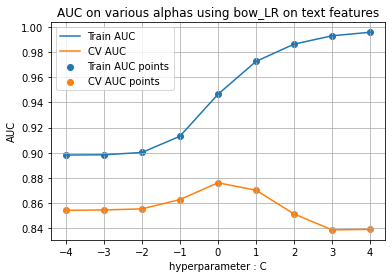

In [49]:
Train_data(x_train_bow,y_train,"bow_LR" )

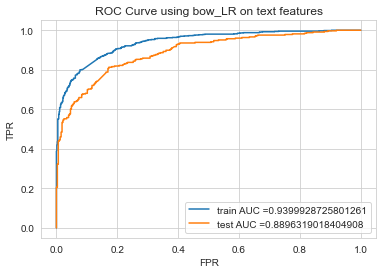

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.7417574837908677 for threshold 0.405
Train confusion matrix
[[604  55]
 [131 529]]


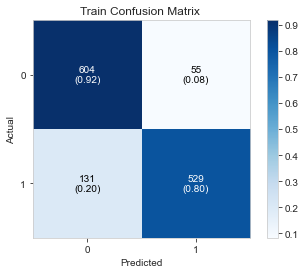

Test confusion matrix


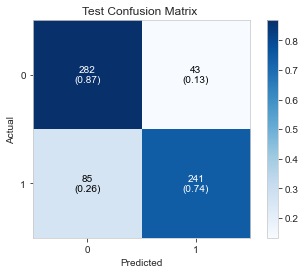

In [50]:
Test_Data(x_train_bow, y_train,x_test_bow,y_test,1,"bow_LR")

### Hyperparam tuning and Checking the results of Tfidf

The best parameters for using this model is {'C': 1}
Best Estimator  LogisticRegression(C=1, class_weight='balanced')


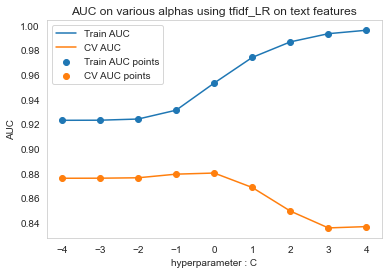

In [51]:
Train_data(x_train_tfidf,y_train,"tfidf_LR" )

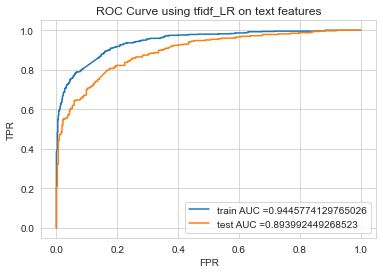

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.7515059548443463 for threshold 0.331
Train confusion matrix
[[605  54]
 [134 526]]


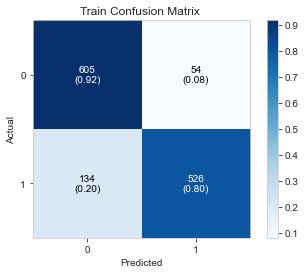

Test confusion matrix


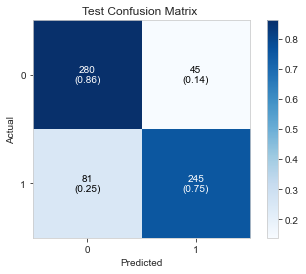

In [52]:
Test_Data(x_train_tfidf, y_train,x_test_tfidf,y_test,1,"tfidf_LR")

### Hyperparam tuning and Checking the results of SentenceTransformer

The best parameters for using this model is {'C': 1}
Best Estimator  LogisticRegression(C=1, class_weight='balanced')


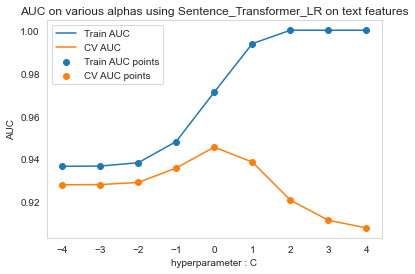

In [53]:
Train_data(x_train_transformer,  y_train, "Sentence_Transformer_LR")

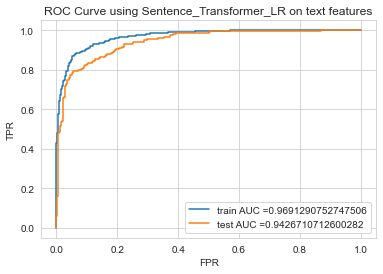

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.8258380466271209 for threshold 0.422
Train confusion matrix
[[606  53]
 [ 71 589]]


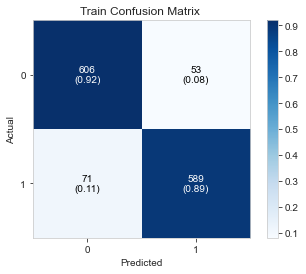

Test confusion matrix
[[284  41]
 [ 50 276]]


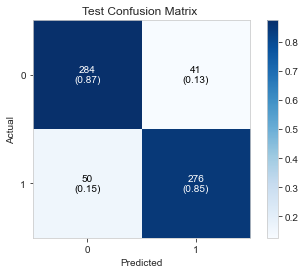

In [54]:
Test_LR(x_train_transformer, y_train,x_test_transformer,y_test,1,"Sentence_Transformer_LR")

### Hyperparam tuning and Checking the results of SentenceTransformer cleaned

The best parameters for using this model is {'C': 1}
Best Estimator  LogisticRegression(C=1, class_weight='balanced')


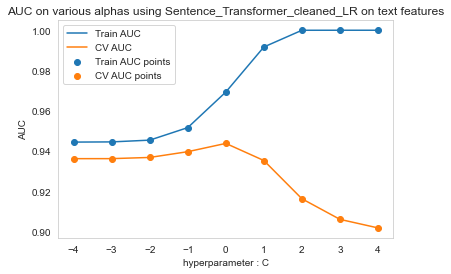

In [55]:
Train_data(x_train_transformer_1,  y_train, "Sentence_Transformer_cleaned_LR")

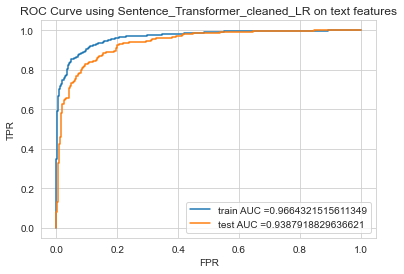

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.8179059180576631 for threshold 0.228
Train confusion matrix
[[597  62]
 [ 69 591]]


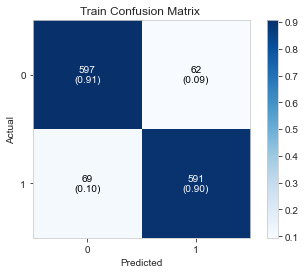

Test confusion matrix
[[283  42]
 [ 49 277]]


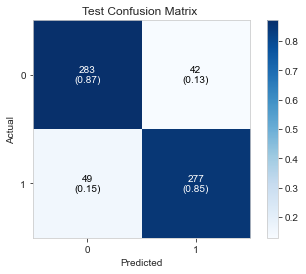

In [56]:
Test_LR(x_train_transformer_1, y_train,x_test_transformer_1,y_test,1,"Sentence_Transformer_cleaned_LR") 

The best parameters for using this model is {'max_depth': 9, 'n_estimators': 500}
Best Estimator  RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=500)
HeatMap of Train and CV


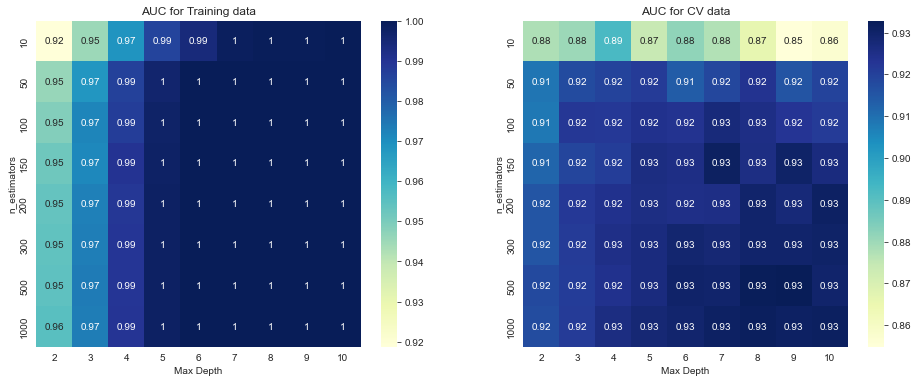

In [76]:
Train_data_RF(x_train_transformer,  y_train, "Sentence_Transformer_RF")

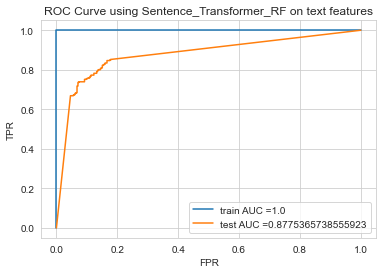

Train confusion matrix
the maximum value of tpr*(1-fpr) 1.0 for threshold 1.0
Train confusion matrix
[[659   0]
 [  0 660]]


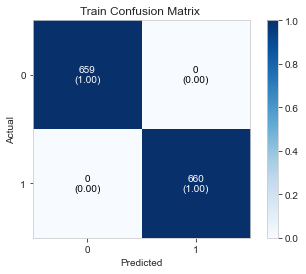

Test confusion matrix
[[290  35]
 [ 79 247]]


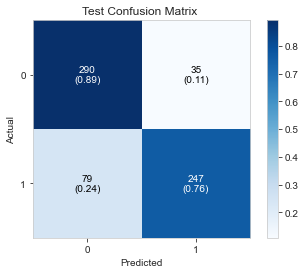

In [86]:
Test_RF(x_train_transformer, y_train,x_test_transformer,y_test, max_depth=9, n_estimators=500,vectorizer="Sentence_Transformer_RF")

The best parameters for using this model is {'max_depth': 8, 'n_estimators': 1000}
Best Estimator  RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=1000)
HeatMap of Train and CV


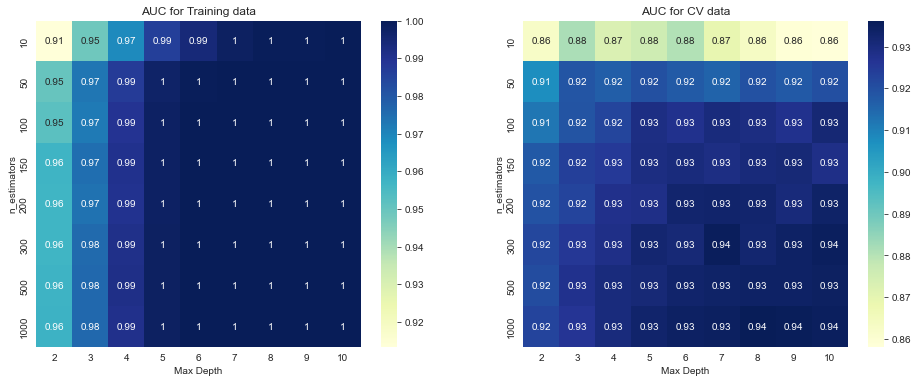

In [57]:
Train_data_RF(x_train_transformer_1,  y_train, "Sentence_Transformer_cleaned_RF")

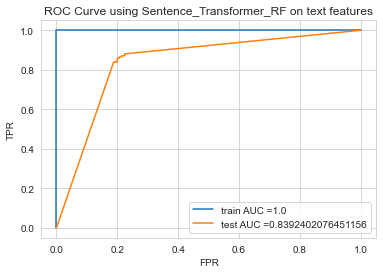

Train confusion matrix
the maximum value of tpr*(1-fpr) 1.0 for threshold 1.0
Train confusion matrix
[[659   0]
 [  0 660]]


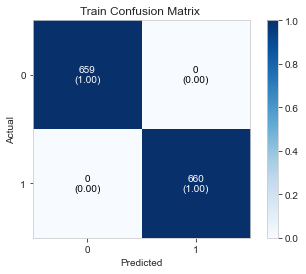

Test confusion matrix
[[258  67]
 [ 44 282]]


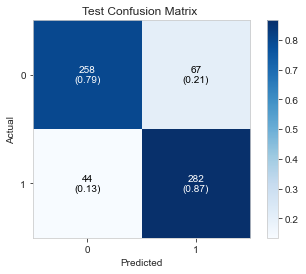

In [87]:
Test_RF(x_train_transformer_1, y_train,x_test_transformer_1,y_test, max_depth=8, n_estimators=1000,vectorizer="Sentence_Transformer_cleaned_RF")

In [58]:

def bow_vectorize(X_test):
    count_vect = read_pickle(BOW_VECT_PICKLE)
    w_normalized = read_pickle(BOW_NORM_PICKLE)

    test_bow = count_vect.transform(X_test)

    print("the shape of out text BOW vectorizer ",test_bow.get_shape())
    print("the number of unique words ", test_bow.get_shape()[1])

    return w_normalized.transform(test_bow)

def tfidf_vectorize(X_test):
    vectorizer = read_pickle(TfIDf_VECT_PICKLE)
    w_normalized = read_pickle(TfIDf_NORM_PICKLE)

    test_tfidf = vectorizer.transform(X_test)
    print("the shape of out text tfidf vectorizer ",train_tfidf.get_shape())
    print("the number of unique words ", train_tfidf.get_shape()[1])

    return w_normalized.transform(test_tfidf)
    

## Test the model with unseen data

In [88]:
## Test for unseen data
sample_str = "i m very happy no regrets"
vectorizer_list = ['bow_LR', "tfidf_LR","Sentence_Transformer_LR",'Sentence_Transformer_cleaned_LR',
                   'Sentence_Transformer_RF','Sentence_Transformer_cleaned_RF']

bow_li=[]
tf_li=[]
sent_trans_lr= []
sent_trans_lr_clean= []
sent_trans_rf= []
sent_trans_rf_clean= []
clean_text= []
for index, row in unseen_data_to_check.iterrows():

    sample_str = row['comment_text']
    clean_str = clean_data(sample_str)
    clean_text.append(clean_str)
    test_str = pd.Series(clean_str)
    
    for i in vectorizer_list:
        vectorizer = i
        
        if(vectorizer=='bow_LR'):
            test_str1 = test_str.apply(create_spacy_tokens)
            X_test = bow_vectorize(test_str1)
            model_name = vectorizer+".pkl"
            model = read_pickle(model_name)

            predicted =  model.predict(X_test)
            bow_li.append(predicted[0])
            
        elif(vectorizer=='Sentence_Transformer_LR'):
            X_test = sent_transformer_model.encode(test_str)
            model_name = vectorizer+".pkl"
            model = read_pickle(model_name)

            predicted =  model.predict(X_test)
            sent_trans_lr.append(predicted[0])
            
        elif(vectorizer=='Sentence_Transformer_cleaned_LR'):
            test_str1 = test_str.apply(create_spacy_tokens)
            X_test = sent_transformer_model.encode(test_str1)
            model_name = vectorizer+".pkl"
            model = read_pickle(model_name)

            predicted =  model.predict(X_test)
            sent_trans_lr_clean.append(predicted[0])
        
        elif(vectorizer=='Sentence_Transformer_RF'):
            X_test = sent_transformer_model.encode(test_str)
            model_name = vectorizer+".pkl"
            model = read_pickle(model_name)

            predicted =  model.predict(X_test)
            sent_trans_rf.append(predicted[0])
        
        elif(vectorizer=='Sentence_Transformer_cleaned_RF'):
            X_test = sent_transformer_model.encode(test_str)
            model_name = vectorizer+".pkl"
            model = read_pickle(model_name)

            predicted =  model.predict(X_test)
            sent_trans_rf_clean.append(predicted[0])

        else:   
            test_str1 = test_str.apply(create_spacy_tokens)
            X_test = tfidf_vectorize(test_str1)
            model_name = vectorizer+".pkl"
            model = read_pickle(model_name)
            predicted =  model.predict(X_test)
            tf_li.append(predicted[0])


preceding unsigned comment added by talk contribs
cleaned :: precede unsigned comment add talk contrib
the shape of out text BOW vectorizer  (1, 247)
the number of unique words  247
preceding unsigned comment added by talk contribs
cleaned :: precede unsigned comment add talk contrib
the shape of out text tfidf vectorizer  (1319, 247)
the number of unique words  247
preceding unsigned comment added by talk contribs
cleaned :: precede unsigned comment add talk contrib
you are a mindless faggot pig please god burn this fucking maggot to death in hellyou have offended my senses you mindless self important fucking pestthe god that you hate hates you
cleaned :: mindless faggot pig god burn fucking maggot death hellyou offend sense mindless self important fucking pestthe god hate hate
the shape of out text BOW vectorizer  (1, 247)
the number of unique words  247
you are a mindless faggot pig please god burn this fucking maggot to death in hellyou have offended my senses you mindless self imp

you know for human excrement youre pretty fast to find vandalism good job you have a purpose in life
cleaned :: know human excrement pretty fast find vandalism good job purpose life
the shape of out text BOW vectorizer  (1, 247)
the number of unique words  247
you know for human excrement youre pretty fast to find vandalism good job you have a purpose in life
cleaned :: know human excrement pretty fast find vandalism good job purpose life
the shape of out text tfidf vectorizer  (1319, 247)
the number of unique words  247
you know for human excrement youre pretty fast to find vandalism good job you have a purpose in life
cleaned :: know human excrement pretty fast find vandalism good job purpose life
noel you are an expert please convince whig history fans or the lazy minds about how bonnie prince charlie did not want to dissolve the union that the united kingdom began with the stuarts as opposed to the hanoverians tell them how the whigs rewrote history to blame everything on the stuar

curse wikipedia has no respect for god wikipedia is full of lies or dangerously evil half truths wikipedia has no respect for religion the following users of wikipedia namely redtigerxyz priyanath emperor genius raj wikidas wikiveer and dagizza have all committed blasphemy and sacrilage curse upon you that you will all perish i curse the following users of wikipedia namely redtigerxyz priyanath emperor genius raj wikidas wikiveer and dagizza that you will all perish i curse that the wikipedia will entirely perish i beg forgiveness from the supreme god lord vishnu for choosing the blasphemous wikipedia website to write about the truth a true devote of the supreme lord vishnu has been hurt and my curse never goes in vain i will never again edit or read or go to the evil wikipedia website forever delete my user id and all edits you evil wikipedians mr dagizza you are a male chauvinist pig and a misogynist to the core and you call yourself an administrator ridiculous mr dagizza you are a c

fuck you faggot i dont care if i get blocked as long as everyone knows you are a dumb cunt
cleaned :: fuck faggot I care I block long know dumb cunt
the shape of out text BOW vectorizer  (1, 247)
the number of unique words  247
fuck you faggot i dont care if i get blocked as long as everyone knows you are a dumb cunt
cleaned :: fuck faggot I care I block long know dumb cunt
the shape of out text tfidf vectorizer  (1319, 247)
the number of unique words  247
fuck you faggot i dont care if i get blocked as long as everyone knows you are a dumb cunt
cleaned :: fuck faggot I care I block long know dumb cunt
sorry but the guy is a pratt he has attacked me before so needs to practise what he preaches
cleaned :: sorry guy pratt attack I need practise preach
the shape of out text BOW vectorizer  (1, 247)
the number of unique words  247
sorry but the guy is a pratt he has attacked me before so needs to practise what he preaches
cleaned :: sorry guy pratt attack I need practise preach
the shape o

i thought i would offer you some advise aswell no wikipedia edit warring no arguing with wikipedia administrators may i also remind you of the three revert rule
cleaned :: I think I offer advise aswell wikipedia edit war arguing wikipedia administrator I remind revert rule
the shape of out text BOW vectorizer  (1, 247)
the number of unique words  247
i thought i would offer you some advise aswell no wikipedia edit warring no arguing with wikipedia administrators may i also remind you of the three revert rule
cleaned :: I think I offer advise aswell wikipedia edit war arguing wikipedia administrator I remind revert rule
the shape of out text tfidf vectorizer  (1319, 247)
the number of unique words  247
i thought i would offer you some advise aswell no wikipedia edit warring no arguing with wikipedia administrators may i also remind you of the three revert rule
cleaned :: I think I offer advise aswell wikipedia edit war arguing wikipedia administrator I remind revert rule
geometry of lov

In [89]:
unseen_data_to_check['bow'] = bow_li
unseen_data_to_check['tf'] = tf_li
unseen_data_to_check['sent_trans_lr'] = sent_trans_lr
unseen_data_to_check['sentTrans_cleaned_lr'] = sent_trans_lr_clean
unseen_data_to_check['sent_trans_rf'] = sent_trans_rf
unseen_data_to_check['sentTrans_cleaned_rf'] = sent_trans_rf_clean
unseen_data_to_check['clean_text'] =clean_text
unseen_data_to_check

,comment_text,toxic,bow,tf,sent_trans,sentTrans_cleaned,clean_text,sent_trans_lr,sentTrans_cleaned_lr,sent_trans_rf,sentTrans_cleaned_rf
676,"""\n— Preceding unsigned comment added by (tal...",0,0,0,0,0,preceding unsigned comment added by talk contribs,0,0,0,0
3919,YOU ARE A MINDLESS FAGGOT PIG PLEASE GOD BURN ...,1,1,1,1,1,you are a mindless faggot pig please god burn ...,1,1,1,1
25,Radial symmetry \n\nSeveral now extinct lineag...,0,0,0,0,0,radial symmetry several now extinct lineages i...,0,0,0,0
2176,What the fuck gose here,1,1,1,1,1,what the fuck gose here,1,1,1,1
8421,"""\n""""To denude it of its context is obscene?""""...",1,0,0,1,0,to denude it of its context is obscene what on...,1,0,0,1
7823,"""\nYou idiot, you did not provide a source for...",1,0,0,1,1,you idiot you did not provide a source for thi...,1,1,0,0
476,F**K ALL RIDES AT WORLDS OF FUN \n\nI hate al...,1,1,1,1,1,f k all rides at worlds of fun i hate all ride...,1,1,1,1
2826,"You know, for human excrement, you're pretty f...",1,0,0,1,1,you know for human excrement youre pretty fast...,1,1,1,1
617,"Noel, you are an expert. Please convince Whig...",0,1,1,0,0,noel you are an expert please convince whig hi...,0,0,0,0
1095,"""\n Thanks ) • You Da One """,0,0,0,0,0,thanks you da one,0,0,0,1


In [92]:
count_bow_lr = 0
count_tf_lr = 0
count_sent_lr = 0
count_sent_cleaned_lr = 0
count_sent_rf = 0
count_sent_cleaned_rf= 0
for index, row in unseen_data_to_check.iterrows():
    
    if(row['toxic'] == row['bow']):
        count_bow_lr+=1
        
    if(row['toxic'] == row['tf']):
        count_tf_lr+=1
        
    if(row['toxic'] == row['sent_trans_lr']):
        count_sent_lr+=1
        
    if(row['toxic'] == row['sentTrans_cleaned_lr']):
        count_sent_cleaned_lr+=1
    
    if(row['toxic'] == row['sent_trans_rf']):
        count_sent_rf+=1
        
    if(row['toxic'] == row['sentTrans_cleaned_rf']):
        count_sent_cleaned_rf+=1
        
    else:
        print("index ::", index)
print(count_bow_lr,count_tf_lr, count_sent_lr,count_sent_cleaned_lr,count_sent_rf,count_sent_cleaned_rf)
unseen_data_to_check.shape

index :: 7823
index :: 1095
index :: 794
index :: 1219
index :: 259
24 24 26 27 25 25


(30, 11)

In [62]:
import spacy
import string

spacy_model = spacy.load("en_core_web_sm")

doc_1 = spacy_model('Hi there, how are you?')
doc_2 = spacy_model('Hello there, how are you doing today?')
print(doc_1.similarity(doc_2[0:7]))

0.6971590061885349


In [63]:
import spacy_sentence_bert
# load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
nlp = spacy_sentence_bert.load_model('en_stsb_roberta_large')
# get two documents
doc_1 = nlp('Hi there, how are you?')
doc_2 = nlp('Hello there, how are you doing today?')
# use the similarity method that is based on the vectors, on Doc, Span or Token

tokens = [ word.text.lower() for word in doc_1 ]
print(tokens)

print(doc_1.similarity(doc_2[0:7]))
print(doc_1.text)


from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

['hi', 'there', ',', 'how', 'are', 'you', '?']
0.7491616554299715
Hi there, how are you?
Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173422e-02 -4.28515524e-02 -1.56286303e-02  1.40537536e-02
  3.95538025e-02  1.21796302e-01  2.94333193e-02 -3.17524150e-02
  3.54959927e-02 -7.93139860e-02  1.75878443e-02 -4.04369161e-02
  4.97259870e-02  2.54912600e-02 -7.18700439e-02  8.14968869e-02
  1.47070654e-03  4.79627885e-02 -4.50336076e-02 -9.92174894e-02
 -2.81769559e-02  6.45045489e-02  4.44670320e-02 -4.76217307e-02
 -3.52952480e-02  4.38671373e-02 -5.28565906e-02  4.33030975e-04
  1.01921506e-01  1.64072253e-02  3.26996259e-02 -3.45986933e-02
  1.21339215e-02  7.94870853e-02  4.58342116e-03  1.57778915e-02
 -9.68206488e-03  2.87626106e-02 -5.05806170e-02 -1.55793978e-02
 -2.87906677e-02 -9.62283742e-03  3.15556675e-02  2.27349307e-02
  8.71449634e-02 -3.85027267e-02 -8.84718373e-02 -8.75497889e-03
 -2.12343764e-02  2.08923724e-02 -9.02077556e-02 -